In [1]:
import pandas as pd
import sys
from imp import reload
sys.path.insert(0, "/media/diskD/EPFL/Fall 2016/ADA/Homework/Gokcen_Meryem_Riyadh_ADA/05 - Taming Text/HelperFunctions")
from preprocessing import *
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)
from __future__ import division
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pycountry
import community
import networkx as nx
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from collections import Counter
import pyLDAvis.gensim as gensimvis
import pyLDAvis
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/home/meryem/miniconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/meryem/miniconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/meryem/miniconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/meryem/miniconda2/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the c

# I. Exploratory Data Analysis:

In [2]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv',encoding="utf-8")
emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,ExtractedSubject,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545/C05739545.pdf,F-2015-04841,HRC_Email_296,FW: Wow,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739545\nDate: 05/13/20...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546/C05739546.pdf,F-2015-04841,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc ...",UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739546\nDate: 05/13/20...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547/C05739547.pdf,F-2015-04841,HRC_Email_296,Re: Chris Stevens,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739547\nDate: 05/14/20...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550/C05739550.pdf,F-2015-04841,HRC_Email_296,FVV: Cairo Condemnation - Final,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739550\nDate: 05/13/20...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554/C05739554.pdf,F-2015-04841,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11, 2011 1:36 PM\nHuma Abedin\nFw: H: Latest: How Syr...",B6\nUNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739554\nDate: 05/1...


In [3]:
emails.shape

(7945, 22)

In [4]:
emails.columns

Index([u'Id', u'DocNumber', u'MetadataSubject', u'MetadataTo', u'MetadataFrom',
       u'SenderPersonId', u'MetadataDateSent', u'MetadataDateReleased',
       u'MetadataPdfLink', u'MetadataCaseNumber', u'MetadataDocumentClass',
       u'ExtractedSubject', u'ExtractedTo', u'ExtractedFrom', u'ExtractedCc',
       u'ExtractedDateSent', u'ExtractedCaseNumber', u'ExtractedDocNumber',
       u'ExtractedDateReleased', u'ExtractedReleaseInPartOrFull',
       u'ExtractedBodyText', u'RawText'],
      dtype='object')

In [5]:
pd.isnull(emails).any()

Id                              False
DocNumber                       False
MetadataSubject                  True
MetadataTo                       True
MetadataFrom                     True
SenderPersonId                   True
MetadataDateSent                 True
MetadataDateReleased            False
MetadataPdfLink                 False
MetadataCaseNumber              False
MetadataDocumentClass           False
ExtractedSubject                 True
ExtractedTo                      True
ExtractedFrom                    True
ExtractedCc                      True
ExtractedDateSent                True
ExtractedCaseNumber              True
ExtractedDocNumber               True
ExtractedDateReleased            True
ExtractedReleaseInPartOrFull    False
ExtractedBodyText                True
RawText                         False
dtype: bool

In [6]:
# The percentage of emails with null ExtractedBodyText
round(len(emails[emails['ExtractedBodyText'].isnull()])/len(emails)*100,2)

15.14

By looking at the columns values and after understanding the table schema, we can conclude that the columns which are relevant for our tasks are columns which carry body text content and those are metadataSubject, ExtractedSubject, RawText, ExtractedBodyText,.... Since RawText aggregates all this information, we can focus on only RawText. So we can get rid of columns about date, ids, metadata of sender, receiver, etc. Now, we are faced with two choices: either keep RawText which doesn't have any nan values, but has a lot of noisy data or use ExtractedBodyText which is so much cleaner and lose only 15% of the content. So, we decided to discard RawText and use ExtractedBodyText instead. Other columns of interest include ExtractedSubject, Sender and Receiver which we used later for topic modelling and graph communities later on.

Before we proceed with our tasks, let's replace nan values in ExtractedBodyText with empty string so that we don't lose any information related to sender and receiver in those rows:

In [7]:
emails['ExtractedBodyText'] = emails['ExtractedBodyText'].fillna('')

# Exercise 1: Generate a word cloud based on the raw corpus

### Strategy:
We will start with a basic word cloud before applying any pre-processing operations. Then, we will do it again after applying pre-processing to see what changes and how pre-processing can improve it (or if it makes it worse).


### 1.1. Before Pre-Processing:

In order to construct our WordCloud, we first need to have all emails content as a big string that is treated by the algorithm in wordCloud library to count word frequencies.

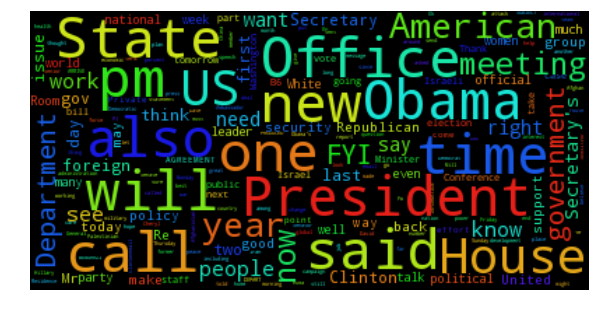

In [8]:
# Getting the ExtractedBodyText and putting it into a list
emails_list =[]
for index,row in emails.iterrows():
    emails_list.append(row['ExtractedBodyText'])

# Merging all emails ExtractedBodyText content into one big string 
sep = ' '
joined_text = sep.join(emails_list)

# Passing joined_text as an argument to method WordCloud in wordCloud library to generate word cloud  
wordcloud = WordCloud(max_font_size=40,background_color="black", max_words=200).generate(joined_text)

# Displaying a word cloud image
plt.figure(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We notice that this word cloud contains a lot of noisy words that are not very representative of the true content of emails. It is normal to see some useless words like Re, two, well, new, will, one, pm since they are being used more frequently just like stopwords. In the second part, we will get rid of them as much as so that we can bring to the surface real keywords that carry more important meaning. 

### 1.2. After Preprocessing:

### Strategy:
1. Tokenization and replacing contractions
2. Part of Speech Tagging to distinguish nouns, verbs (this information will be used later on in lemmatization) 
3. Stopword and Punctuation removal
4. Stemming, Lemmatization and term normalization
5. Term Normalization: replacing synonyms and different representations of one word with one common representation
    => Bag of words representation of raw text

#### NB:
We will explain in what follows our whole pre-processing pipeline with details. For further investigation, you can have a look at the code which is provided in a separate python file called preprocessing.py in folder HelperFunction.  

### a. Replacing contractions and tokenization
Before tokenization, we start by replacing contractions in the emails text. Some examples include I'm, you're, he's. We have compiled an exhaustive list of all possible contractions in english and we replaced all instances of I'm, you're,... with I am, you are. We believe it makes a difference afterwards during tokenization. If we don't do it, you're will be separated into you and 're and we will not be able to distinguish 're from are which is a stopword.

In [9]:
emails = replace_contractions(emails)

After that, we included some terms to be normalized. For example U.S. is a different version of US. If we tokenize we lose it as it is going to be separated into U and S.

In [10]:
emails_normalized = term_normalization(emails)

Now, we proceed with word tokenization based on white spaces. For this purpose, we use RegexpTokenizer which splits a string into substrings using regular expression. It forms tokens out of alphabetic sequences, money expressions and any other non-whitespaces. The downside of this tokenizer is that it doesn't exclude punctuation and numbers but this is not a problem since we will remove them later on. At this stage, we also convert everything to lower case.

In [11]:
email_bag_words = bag_of_word_representation(emails_normalized)

### b. Part of Speech Tagging to distinguish nouns, verbs (this information will be used later on in lemmatization) 

Now, before removing punctuation, numbers and stopwords, we will perform part of speech tagging to find nouns, verbs, adjectives, pronouns, conjunctions etc. This is very important as we believe that words that carry more important meaning are nouns, verbs, adjectives and adverbs which we will keep. 

In [13]:
tagged_emails = pos_tagging(email_bag_words)

### c. Punctuation and Stopword removal

Now, we remove punctuation, numbers and stopwords. In order to make sure we remove not only standard english stop words that we can get from nltk, but also noisy words specific to the context of emails, we add a list of customized stopwords with words like 'say','unclassified','call', 'know', 'would', 'get', 'time', 'work', 'like', 'today', 'see', 'morning', 'also', 'back', 'tomorrow', 'meeting' which we filter out in an iterative manner by looking at wordclouds and thinking which words are not representatives and need to be included in the list of stopwords. 

In [14]:
tagged_emails_without = punctuation_numbers_stopword_removal(tagged_emails)

In [15]:
tagged_emails_without_normalized = normalize_nava_tags(tagged_emails_without)

### d. Lemmatization and term normalization

In order to normalize the terms and get one common representation of multiple versions of the same word, we decided to use lemmatization. Nltk comes with a very performant and highly accurate WordNetLemmatizer which can reduce any word into its radical form (for example plural (mothers) to singular nouns (mother), conjugated verbs (procrastinating) to infinitive (procrastinate)) as long as it knows its part of speech tag to apply lemmatization rules relevant to this specific type. We decided not to use stemming since this will cut down words and generate words that don't exist.

In [16]:
tagged_emails_without_normalized_lemma = lemmatizer(tagged_emails_without_normalized)

### e. Flatten the list of words and Joining words to form one string

In [17]:
email_bag_flat = flat_tag_bag_of_word_representation(tagged_emails_without_normalized_lemma)

In [18]:
sep = ' '
joined_text = sep.join(email_bag_flat)

### f. Drawing Word Count Cloud

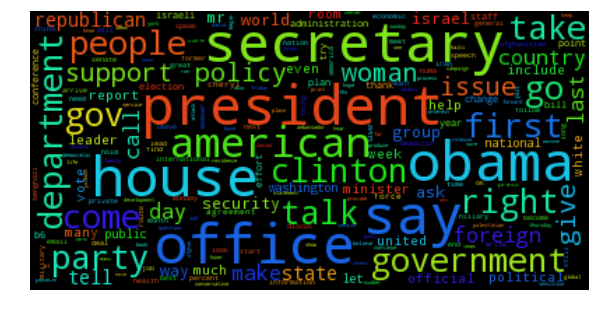

In [19]:
wordcloud = WordCloud(max_font_size=40,background_color="black", max_words=200).generate(joined_text)
plt.figure(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

There are many improvements that we noticed with this word cloud version. First of all, we removed a lot of meaningless words, which were omnipresent in the emails (the Re:, FW: and others), and hence we see more clearly what actualy are the topic of the emails. We see that one of the most proeminent words is state, which is expected to be commonly found as Hillary Clinton was secretary of state, and state speaks also about the states in the United States, ... We also find the words obama, house, secretary, office, which are all very common words. The only downside here, is that we lost the capital letters in the process, which is necessary in the process of finding the stop words. (It could be done otherwise, but the work would end up being much more complicated).


# Exercise 2: World countries and Sentiment Analysis

### Task: 
The objective of this question is to find all mentions of world countries in all emails and to aggregate the polarity information of all emails by country

### Strategy:
We will start by constructing a mapping between each email and world countries and extract the most dominant country in the email.
Then, we will find the dominant sentiment in the email. 
1. Iterating over emails, finding countries occurences (using different forms) and building mappings between emails and countries => list of countries per each email
2. Trying different sentiment analysis demo methods of the emails
3. Aggregating sentiments of emails by country
4. Data Visualization

### 2.1. Countries Names: Normalization of different surface forms for the same country

### a. Looking for countries mentions in the emails:

In [ ]:
for country in pycountry.countries:
    print country.name + ","+ country.alpha_2

We went over the names of the countries and we tried to represent them in their commonly used form. For example, people are more likely to say Iran rather than using the full name Iran, Islamic Republic. 

In [ ]:
countries_customized = [('Syria','SY'),('Congo','CD'),('Britain','UK'),('Iran','IR'),('South Korea','KR'),('North Korea','KP'),('Macedonia','MK'),('Russia','RU'),('Taiwan','TW'),('Tanzania','TZ'),('Palestine','PS'),('Moldova','MD'),('Bolivia','BO')]
for country in pycountry.countries:
    countries_customized.append((country.name,country.alpha_2))
to_be_removed = [("Iran, Islamic Republic of","IR"),("Korea, Republic of","KR"),("Moldova, Republic of","MD"),("Macedonia, Republic of","MK"),("Korea, Democratic People's Republic of","KP"),("Palestine, State of","PS"),("Taiwan, Province of China","TW"),("Tanzania, United Republic of","TZ"),("Venezuela, Bolivarian Republic of","VE"),("Bonaire, Sint Eustatius and Saba","BQ"),("Bolivia, Plurinational State of","BO"),("Syrian Arab Republic","SY")]
for (country,abb) in to_be_removed:
    countries_customized.remove((country,abb))
countries_customized

In [ ]:
emails_lemma_untagged = untag_lemma_emails(tagged_emails_without_normalized_lemma)
countries_mentions = []
for i in range(0,len(emails_lemma_untagged)):
    countries_mentions_sub = []
    print i
    for word in emails_lemma_untagged[i]:
        for (name,alpha_2) in countries_customized:
            if word == name.lower() or word == alpha_2.lower(): 
            #or word == country.alpha_2.lower() or word == country.alpha_3.lower():
                countries_mentions_sub.append(name.lower())
    countries_mentions.append(countries_mentions_sub)

### b. Calculating the frequencies of the countries:

In [ ]:
countries_list = [country for sublist in countries_mentions for country in sublist]
frequencies = {}
for country in set(countries_list):
    frequencies[country] = 0
for email in countries_mentions:
    for country in set(countries_list):
        if country in email:
            frequencies[country] += 1
        
frequencies

In [ ]:
countries_list

## 2.2. Trying different sentiment analysis demo methods of the emails

### a. Joining the words in email to have one sentence string

In [ ]:
sep = ' '
joined_emails = []
for email in emails_lemma_untagged:
    joined_emails.append(sep.join(email))

### b. Trying with vader lexicon

In [ ]:
#for email in joined_emails:
str(demo_vader_instance(email[0]))

In [ ]:
email_polarities = []
sid = SentimentIntensityAnalyzer()
for i in range(0,len(joined_emails)):
    email_polarities.append(sid.polarity_scores(joined_emails[i])['compound'])

## 2.3. Aggregating sentiments of emails by country

In [ ]:
# Storing emotion polarity score for each country mentioned in each email 
countries_emotions_whole = []
for i in range(0,len(countries_mentions)):
    for j in range(0,len(countries_mentions[i])):
        countries_emotions_whole.append((countries_mentions[i][j],email_polarities[i]))

countries_emotions_whole_df = pd.DataFrame(countries_emotions_whole, columns=["Country", "Emotion"]) 
# Aggregating Countries by mean of emotion polarities:
countries_emotions_mean = countries_emotions_whole_df.groupby('Country').mean()
countries_emotions_mean['Country'] = countries_emotions_mean.index
countries_frequencies = []
for i in range(0,len(countries_emotions_mean)):
    countries_frequencies.append(frequencies[countries_emotions_mean.iloc[i]['Country']])
countries_emotions_mean['Frequency'] = countries_frequencies
countries_emotions_mean['Frequency'] 
countries_emotions_mean

In [ ]:
countries_emotions_mean_threshold = countries_emotions_mean [countries_emotions_mean['Frequency']>=15]
len(countries_emotions_mean_threshold)

## 2.4. Data Visualization

In [ ]:
%matplotlib inline
import seaborn as sns
import pandas as pd


palette = sns.color_palette("RdBu", n_colors=len(countries_emotions_mean))
countries_emotions_mean.plot(kind='bar', figsize=(14,4), color= palette)

In [ ]:
countries_emotions_whole_df = pd.read_csv('countries_emotions_whole_df.csv',encoding="utf-8")
countries_emotions_mean = countries_emotions_whole_df.groupby('Country').mean()
#countries_emotions_mean['Country']= countries_emotions_mean.index
countries_emotions_mean.reset_index()

In [ ]:
import numpy as np
from matplotlib import cm

# Set up colors : red to green
plt.figure(figsize=(15,5))
y = np.array(countries_emotions_mean_threshold['Emotion'])
colors = cm.RdYlGn(y / float(max(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(range(countries_emotions_mean_threshold.shape[0]), countries_emotions_mean_threshold['Frequency'], align='center', tick_label=countries_emotions_mean_threshold.index, color=colors)
plt.xticks(range(countries_emotions_mean_threshold.shape[0]), countries_emotions_mean_threshold.index, rotation='vertical')

plt.xlabel("Country")
plt.ylabel("Frequency")
plt.show()

In [ ]:
len(joined_emails)

### c. Trying with liu hu lexicon 

In [ ]:
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank

positive = opinion_lexicon.positive()
negative = opinion_lexicon.negative()
tokenizer = treebank.TreebankWordTokenizer()

liu_hu_email_polarities = []
i = 0
for email in joined_emails:
    print i 
    #pol = demo_liu_hu_lexicon(joined_emails[i],positive,negative,tokenizer)
    pol = demo_liu_hu_lexicon(joined_emails[i])
    if pol =='Positive':
        liu_hu_email_polarities.append(1)
    elif pol =='Negative':
        liu_hu_email_polarities.append(-1)
    else: 
        liu_hu_email_polarities.append(0)
    i +=1
liu_hu_email_polarities

In [ ]:
# Storing emotion polarity score for each country mentioned in each email 
countries_emotions_whole = []
for i in range(0,len(countries_mentions)):
    for j in range(0,len(countries_mentions[i])):
        countries_emotions_whole.append((countries_mentions[i][j],email_polarities[i]))

countries_emotions_whole_df = pd.DataFrame(countries_emotions_whole, columns=["Country", "Emotion"]) 
# Aggregating Countries by mean of emotion polarities:
countries_emotions_mean = countries_emotions_whole_df.groupby('Country').mean()
countries_emotions_mean['Country'] = countries_emotions_mean.index
countries_frequencies = []
for i in range(0,len(countries_emotions_mean)):
    countries_frequencies.append(frequencies[countries_emotions_mean.iloc[i]['Country']])
countries_emotions_mean['Frequency'] = countries_frequencies
countries_emotions_mean['Frequency'] 
countries_emotions_mean

In [ ]:
countries_emotions_mean_threshold = countries_emotions_mean [countries_emotions_mean['Frequency']>=15]

In [ ]:
countries_emotions_whole_df = pd.read_csv('countries_emotions_whole_df.csv',encoding="utf-8")
countries_emotions_mean = countries_emotions_whole_df.groupby('Country').mean()
#countries_emotions_mean['Country']= countries_emotions_mean.index
countries_emotions_mean.reset_index()

In [ ]:
import numpy as np
from matplotlib import cm

# Set up colors : red to green
plt.figure(figsize=(15,5))
y = np.array(countries_emotions_mean_threshold['Emotion'])
colors = cm.RdYlGn(y / float(max(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(range(countries_emotions_mean_threshold.shape[0]), countries_emotions_mean_threshold['Frequency'], align='center', tick_label=countries_emotions_mean_threshold.index, color=colors)
plt.xticks(range(countries_emotions_mean_threshold.shape[0]), countries_emotions_mean_threshold.index, rotation='vertical')

plt.xlabel("Country")
plt.ylabel("Frequency")
plt.show()

# Exercise 3: LDA Topic Modelling 

### Task: 
Our task in this exercise is to run topic modelling over the email corpus to map it to a set of different topics.

### Strategy:
1. Creation of large enough documents by concatenating individual emails by threads 
2. Construct corpus and dictionary of the emails
3. Training lda model and infering topic distributions on this corpus 
4. Try with different different number of topics and comparing / printing the topics: going over words per topic and evaluate heterogenity of the topics 

### 3.1. Creation of documents by concatenating individual emails by threads

We have noticed that considering individual emails is not enough for training lda topic modelling as they are not long enough. So, it is necessary to think of a strategy to make the elements passed to lda meaningful enough. There are many options: either aggregating by sender, receiver, date, thread.. We came up with the idea of aggregating the emails according to their subject names and use them as individual elements. Emails which share the same subject description are more likely to talk about the same topic. This is the quickest solution and closest to aggregation by threads. We expect that there are many more emails that belong to the same thread but don't have exactly the same subject (for emails used to reply to another email), but this is expensive to check. 

In [ ]:
from pandas import Series, DataFrame
emails.head()

def f(x):
     return Series(dict(MetadataSubject = x['MetadataSubject'].sum(),  
                        ExtractedBodyText = "%s" % ', '.join(x['ExtractedBodyText'])))
emails_subject_cluster = emails.groupby('MetadataSubject').apply(f)
emails_subject_cluster

### 3.2. Pre-processing of the clustered raw email texts

To pre-process the newly created documents created by clustering emails by subject,  we follow again the same pre-processing steps described earlier including replacing contractions, some term normalization like normalizing U.S. to US, tokenization of sentences to get bag of words, pos tagging to keep only nouns, verbs, adjectives and adverbs, punctuation and stopwords removal, lemmatization, ...

In [ ]:
# Replacing Contractions before tokenization for expressions like I'm and you're to be transformed to I am and you are
emails_subject_cluster = replace_contractions(emails_subject_cluster)

# Replacing many versions of the same word with a common representation
emails_cluster_normalized = term_normalization(emails_subject_cluster)

# Tokenization of emails into bag of words and conversion to lower case
email_bag_words_cluster = bag_of_word_representation(emails_cluster_normalized)

# POS Tagging
tagged_emails_cluster = pos_tagging(email_bag_words_cluster)

# Removal of punctuation, numbers and stopwords
tagged_emails_without_cluster = punctuation_numbers_stopword_removal(tagged_emails_cluster)

# Keeping only words identified previously by pos-tagging as nouns, verbs, adjectives and adverbs 
tagged_emails_without_normalized_cluster = normalize_nava_tags(tagged_emails_without_cluster)

# Lemmatization of words for further term normalization (get rid of plurals, transform verb forms to infinitive)
tagged_emails_without_normalized_lemma_cluster = lemmatizer(tagged_emails_without_normalized_cluster)

In [ ]:
emails_lemma_untag_cluster = untag_lemma_emails(tagged_emails_without_normalized_lemma_cluster)

Unlike in SentimentAnalysis where words like hope, good influence the polarity of the emails, those words in addition to some commonly occuring words don't help distinguish between clusters of topics. By studying the topics' words after trying lda model for the first time, we came accross this list of noisy words that we decided to include as customized stop words for this task.  

In [ ]:
new_stop_words = ['would','today','thx','say','see','new','one','mr','like','call','fyi','yet','also','work','time','get','want','like'
                 'get','talk', 'think','tomorrow','know','good','send','qqdr','let', 'gov','com','case','two','year', 'back','need','next',
                 'last','still','go','best','sure','pls','clintonemail','could','may','mtg','week','way','come','take','well','hope','tell','send','make','print',
                 'f','doc','state','ap','says','many','clinton','even','first','fm','working',
                 'house','thanks','call','meet','pis','local','date','department','meeting','ok','yes','much','list','mail','email','hrc','schedule']

emails_subject = []
for i in range(0, len(emails_lemma_untag_cluster)):
    emails_subject_sub = []
    for word in emails_lemma_untag_cluster[i]:
            if word not in new_stop_words:
                   emails_subject_sub.append(word)
    emails_subject.append(emails_subject_sub)

### 3.3. Construct corpus and dictionary of the emails 

Before training our LDA model to infer topic distribution, we start by creating the email corpus and creating the dictionary. We use gensim functionalities to build corpus which contains for each document the number of occurences of each word and construct list of all words occuring in all email clusters where each word is represented with a unique id.

In [ ]:
from gensim import corpora, models, similarities
from gensim.models import hdpmodel, ldamodel
from itertools import izip

email_dictionary = corpora.Dictionary(emails_subject)
email_corpus = [email_dictionary.doc2bow(email) for email in emails_subject]

### 3.4. Training LDA model and infering topic distributions of the corpus

Next, we train our LDA model using the built dictionary and corpus. We try here with an arbitrary number of topics just to have an initial idea of the returned results and debug in case of problems. 

In [ ]:
lda = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=20)
for top in lda.print_topics(20):
    print top

### 3.4. Trying with different number of topics and Printing and Comparing the results

In order to determine the best value for the number of topics that gives clusters of topics that are heterogenous and meaningful to human common sense, we follow two ways: 
* We train lda model with different number of topics and printing the corresponding top results along with their most commonly occuring words to visualize the disparities by comparing the occurences of different words and what words are used for specific topics and think if words in the same topic have a correlation in real life.
* We use pyLDAvis library which is a cool library that enables 2D visualizatuon of the clusters, their intersections.

After visualization, we will conclude on the number of topics that gives the most heterogenous topics in terms of words occurences.

In [ ]:
lda_50 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=50)

In [ ]:
corpus_lda_50 = lda_50[email_corpus]

for top in lda_50.print_topics(50):
    print top

In [ ]:
vis_data _50 = gensimvis.prepare(lda_50, email_corpus, email_dictionary)
pyLDAvis.display(vis_data)

In [ ]:
lda_40 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=40)
for top in lda_40.print_topics(40):
    print top

In [ ]:
vis_data_40 = gensimvis.prepare(lda_40, email_corpus, email_dictionary)
pyLDAvis.display(vis_data)

In [ ]:
lda_30 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=30)
for top in lda_30.print_topics(30):
    print top

In [ ]:
lda_20 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=20)
for top in lda_20.print_topics(20):
    print top

In [ ]:
lda_7 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=10)
for top in lda_10.print_topics(10):
    print top

In [ ]:
vis_data_7 = gensimvis.prepare(lda_7, email_corpus, email_dictionary)
pyLDAvis.display(vis_data)

In [ ]:
lda_5 = ldamodel.LdaModel(email_corpus, id2word=email_dictionary, num_topics=5)
for top in lda_5.print_topics(5):
    print top

In [ ]:
vis_data_5 = gensimvis.prepare(lda_50, email_corpus, email_dictionary)
pyLDAvis.display(vis_data_5)

# Bonus Question:

### Task: 
Our task for this bonus question is to build the communication graph (unweighted and undirected) among the different email senders and recipients using the `NetworkX` library. 

### Strategy:
1. Build unweighted and undirected communication graph among email senders and recipients
2. Find communities in this graph with `community.best_partition(G)` method from the [community detection module](http://perso.crans.org/aynaud/communities/index.html). 
3. Print the most frequent 20 words used by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
4. Identify clear discussion topics for each community? Discuss briefly the obtained results.


### 4.1. Build Communication graph among email senders and recipients 

### a. Loading Receivers from csv File

In [ ]:
receivers= pd.read_csv('hillary-clinton-emails/EmailReceivers.csv')
receivers.columns=['Receiver_Id','EmailId','Receiver_PersonId']
receivers.head(3)

In [ ]:
receiver_emails=pd.merge(receivers,emails,left_on='EmailId', right_on='Id', how='inner')
receiver_emails=receiver_emails[['RawText','EmailId','SenderPersonId','Receiver_PersonId']]

In [ ]:
persons= pd.read_csv('hillary-clinton-emails/Persons.csv')

### b. Building the vertices and edges of the network

In [ ]:
net=receiver_emails[['SenderPersonId','Receiver_PersonId']]
net=net.dropna(axis=0)
net['SenderPersonId'] = net['SenderPersonId'].astype('int')
s=net['SenderPersonId'].unique().tolist() # getting the list of distinct senders
r=net['Receiver_PersonId'].unique().tolist() # getting the list of distinct receivers
all_users=s+r # concatenating senders and receivers
distinct_users=list(set(all_users)) # getting the list of distinct senders and receivers

### c. Building and Drawing the graph

In [ ]:
G=nx.Graph() # Initializing the graph 
for user in distinct_users:
    G.add_node(user)
net1=net.drop_duplicates(['SenderPersonId','Receiver_PersonId'])
net1.reset_index(inplace=True)
net1=net1.drop('index', axis=1)
def nodes_connected(u, v):
    return u in G.neighbors(v)


for index, row in net1.iterrows():
    s=row['SenderPersonId']
    r=row['Receiver_PersonId']
    if(not nodes_connected(s,r)):
        G.add_edge(s,r)

#first compute the best partition
partition=community.best_partition(G) # is a dictionary where keys are their users and values the communities the users belong to

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                               if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                               node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

In [ ]:
print "For:"+str(len(set(partition.keys())))+" authors, we have: "+str(len(set(partition.values())))+" communities"

In [ ]:
#partition 
author_community_map = pd.DataFrame.from_dict(partition, orient='index')
author_community_map.columns = ['Community']
author_community_map['Author'] = author_community_map.index

In [ ]:
grouped = author_community_map.groupby('Community')

community_authors = grouped.aggregate(lambda x: tuple(x))

community_authors['grouped'] = community_authors['Author']
community_authors = community_authors[['Author']]

In [ ]:
community_authors

### 4.3. Print the most frequent 20 words used by the email authors of each community.

### a. Aggregate / Group by sender

In [ ]:
def f_from(x):
     return Series(dict(RawText = "%s" % ' '.join(x['RawText'])))
emails_cluster_from = receiver_emails.groupby('SenderPersonId').apply(f_from)
emails_cluster_from = emails_cluster_from.reset_index()
emails_cluster_from.columns = [['Author','RawText']]
emails_cluster_from.head()

In [ ]:
receiver_emails.columns

In [ ]:
len(emails_cluster_from)

In [ ]:
community_list = []
for i in range(0, len(emails_cluster_from)):
    community_list.append(partition.get(emails_cluster_from.iloc[i]['Author']))
emails_cluster_from['Community'] = community_list

In [ ]:
emails_cluster_from

### b. Aggregate / Group by receiver

In [ ]:
def f_to(x):
     return Series(dict(RawText = "%s" % ' '.join(x['RawText'])))
emails_cluster_to = receiver_emails.groupby('Receiver_PersonId').apply(f_to)
emails_cluster_to = emails_cluster_to.reset_index()
emails_cluster_to.columns = [['Author','RawText']]
emails_cluster_to.head()

In [ ]:
len(emails_cluster_to)

### c. Concatenate the two aggregations

In [ ]:
concatenated_frames = [emails_cluster_from, emails_cluster_to]
concatenated_emails = pd.concat(concatenated_frames)

### d. Grouping by Author name:

In [ ]:
def f_author(x):
     return Series(dict(RawText = "%s" % ' '.join(x['RawText'])))
emails_cluster_author = concatenated_emails.groupby('Author').apply(f_author)
emails_cluster_author = emails_cluster_author.reset_index()
emails_cluster_author.columns = [['Author','RawText']]
emails_cluster_author.head()
len(emails_cluster_author)
#len(community_authors)

In [ ]:
community_list = []
for i in range(0, len(emails_cluster_author)):
    community_list.append(partition.get(emails_cluster_author.iloc[i]['Author']))
emails_cluster_author['Community'] = community_list

In [ ]:
len(set(emails_cluster_author['Author']))
#partition.values())
#emails_cluster_author['Community'] = partition.values()

In [ ]:
count = 0
for i in range(0,len(receiver_emails)):
    community_sender = partition.get(receiver_emails.iloc[i]['SenderPersonId'])
    community_receiver = partition.get(receiver_emails.iloc[i]['Receiver_PersonId'])
    if community_sender == community_receiver :
        count = count + 1
count / len(receiver_emails) * 100

### e. Pre-processing community_emails:

In [ ]:
emails_community_cluster = replace_contractions(emails_cluster_author)
emails_community_normalized = term_normalization(emails_community_cluster)
email_bag_words_community = bag_of_word_representation(emails_community_normalized)
tagged_emails_community = pos_tagging(email_bag_words_community)
tagged_emails_without_community = punctuation_numbers_stopword_removal(tagged_emails_community)
tagged_emails_without_normalized_community = normalize_nava_tags(tagged_emails_without_community)
tagged_emails_without_normalized_lemma_community = lemmatizer(tagged_emails_without_normalized_community)
emails_lemma_untag_community = untag_lemma_emails(tagged_emails_without_normalized_lemma_community)
email_bag_flat_community = flat_tag_bag_of_word_representation(tagged_emails_without_normalized_lemma_community)
sep = ' '
joined_text_community = sep.join(email_bag_flat_community)

### f. Find 20 most frequent words per each community

In [ ]:
most_frequent_words = []
for i in range(0,len(emails_lemma_untag_community)):
    most_frequent_words_sub = []
    word_counter = Counter(emails_lemma_untag_community[i]) #counts the number each time a word appears
    most_common_tuples = word_counter.most_common(20)
    for (word,frequency) in most_common_tuples:
        most_frequent_words_sub.append(word)
    most_frequent_words.append(most_frequent_words_sub)

In [ ]:
most_frequent_words

### Do these word lists look similar to what you've produced at step 3 with LDA?